# Simulating and Predicting the 2025 NBA Finals

### 1. Import Required Libraries 

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

### 2. Load and Prepare Data

In [144]:
df = pd.read_csv("NBA_2025_Playoff_Series_with_metrics.csv")
df.head()

,Visitor/Neutral,PTS,Win,Home/Neutral,PTS.1,Win.1,Visitor Seed,Home Seed,Year,Visitor_id,...,Home win_pct,Home off_rtg,Home def_rtg,Home net_rtg,Home pace,Home efg_pct,Home ts_pct,Home tov_pct,Home orb_pct,Home drb_pct
0,Indiana Pacers,79,1,Philadelphia 76ers,78,0,8,1,2001,1.610613e+09,...,0.293,111.0,117.3,-6.3,98.13,0.527,0.563,0.138,0.279,0.678
1,Dallas Mavericks,86,0,Utah Jazz,88,1,5,4,2001,1.610613e+09,...,0.207,110.2,119.4,-9.2,100.85,0.533,0.568,0.170,0.311,0.705
2,Minnesota Timberwolves,82,0,San Antonio Spurs,87,1,8,1,2001,1.610613e+09,...,0.415,113.5,116.3,-2.8,100.08,0.544,0.575,0.138,0.278,0.690
3,Charlotte Hornets,106,1,Miami Heat,80,0,6,3,2001,1.610613e+09,...,0.451,112.4,112.0,0.4,97.08,0.544,0.576,0.138,0.263,0.724
4,Toronto Raptors,85,0,New York Knicks,92,1,5,4,2001,1.610613e+09,...,0.622,117.3,113.3,4.0,97.64,0.556,0.589,0.134,0.305,0.710


In [145]:
# Check for missing values
print("Missing Values:")
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Missing Values:
Series([], dtype: int64)


In [146]:
# Define metrics we'll use as features
metrics = ['Seed', 'win_pct', 'off_rtg', 'def_rtg', 'net_rtg', 
           'pace', 'efg_pct', 'ts_pct', 'tov_pct', 'orb_pct', 'drb_pct']

# Create feature differences
for metric in metrics:
    df[f'diff_{metric}'] = df[f'Visitor {metric}'] - df[f'Home {metric}']
    
feature_columns = [f'diff_{metric}' for metric in metrics]

### 3. Exploratory Data Analysis

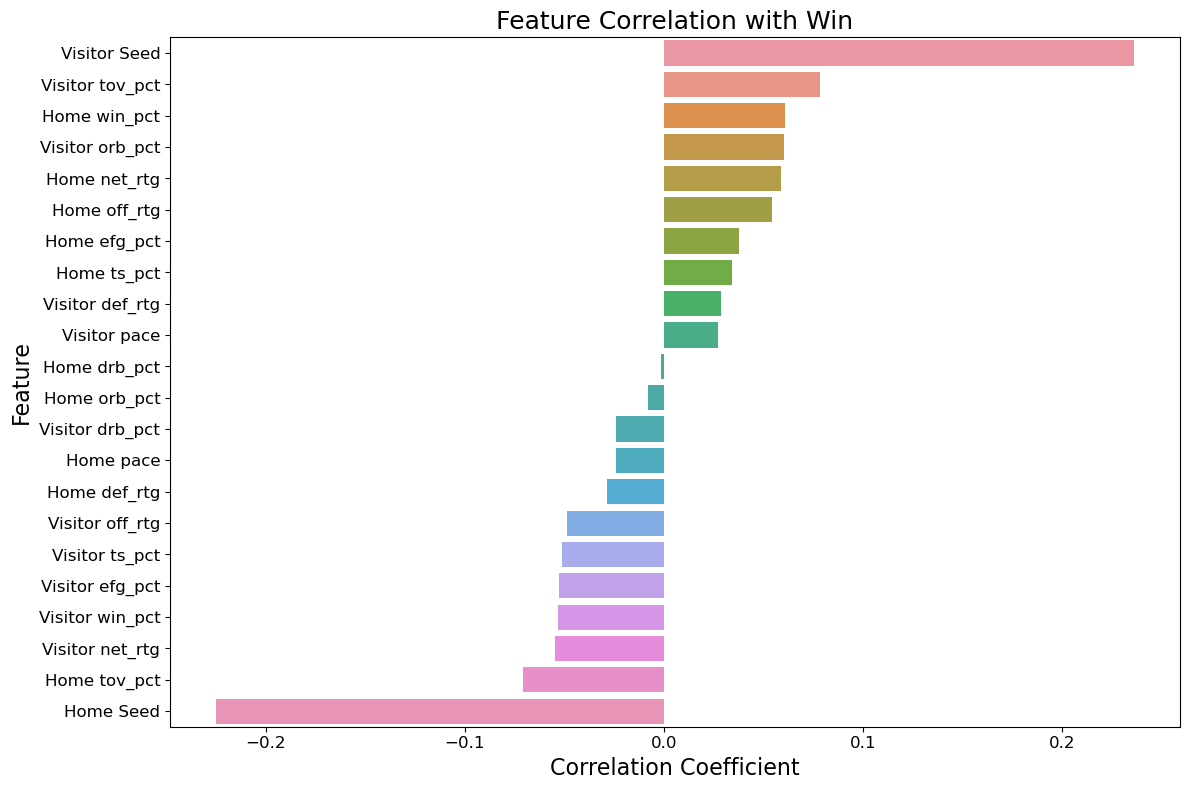

In [147]:
# Correlation between features and target
corr = encoded.corr()
corr_target = corr['Win.1'].drop('Win.1').sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_target.values, y=corr_target.index, orient='h')
plt.title('Feature Correlation with Win', fontsize=18)
plt.xlabel('Correlation Coefficient', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

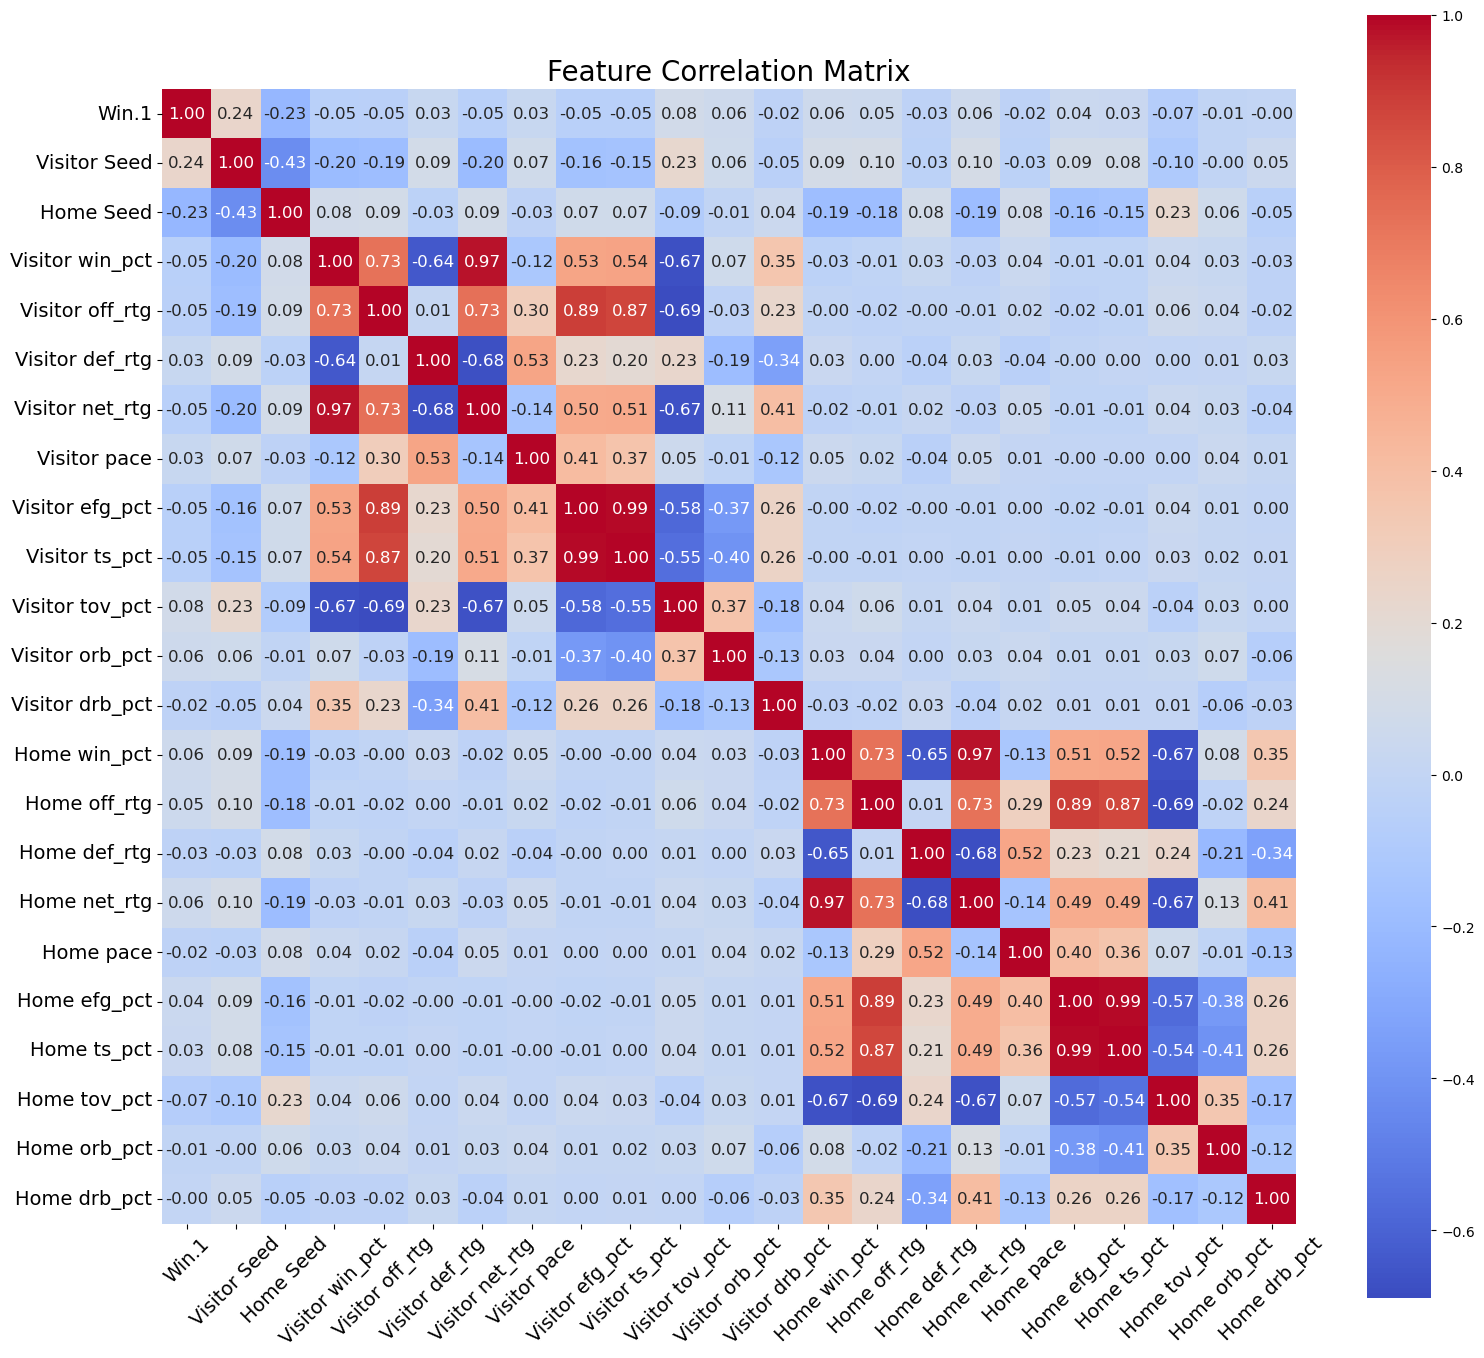

In [148]:
# Correlation between features only
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            annot_kws={'size':12})
plt.title('Feature Correlation Matrix', fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()
plt.show()

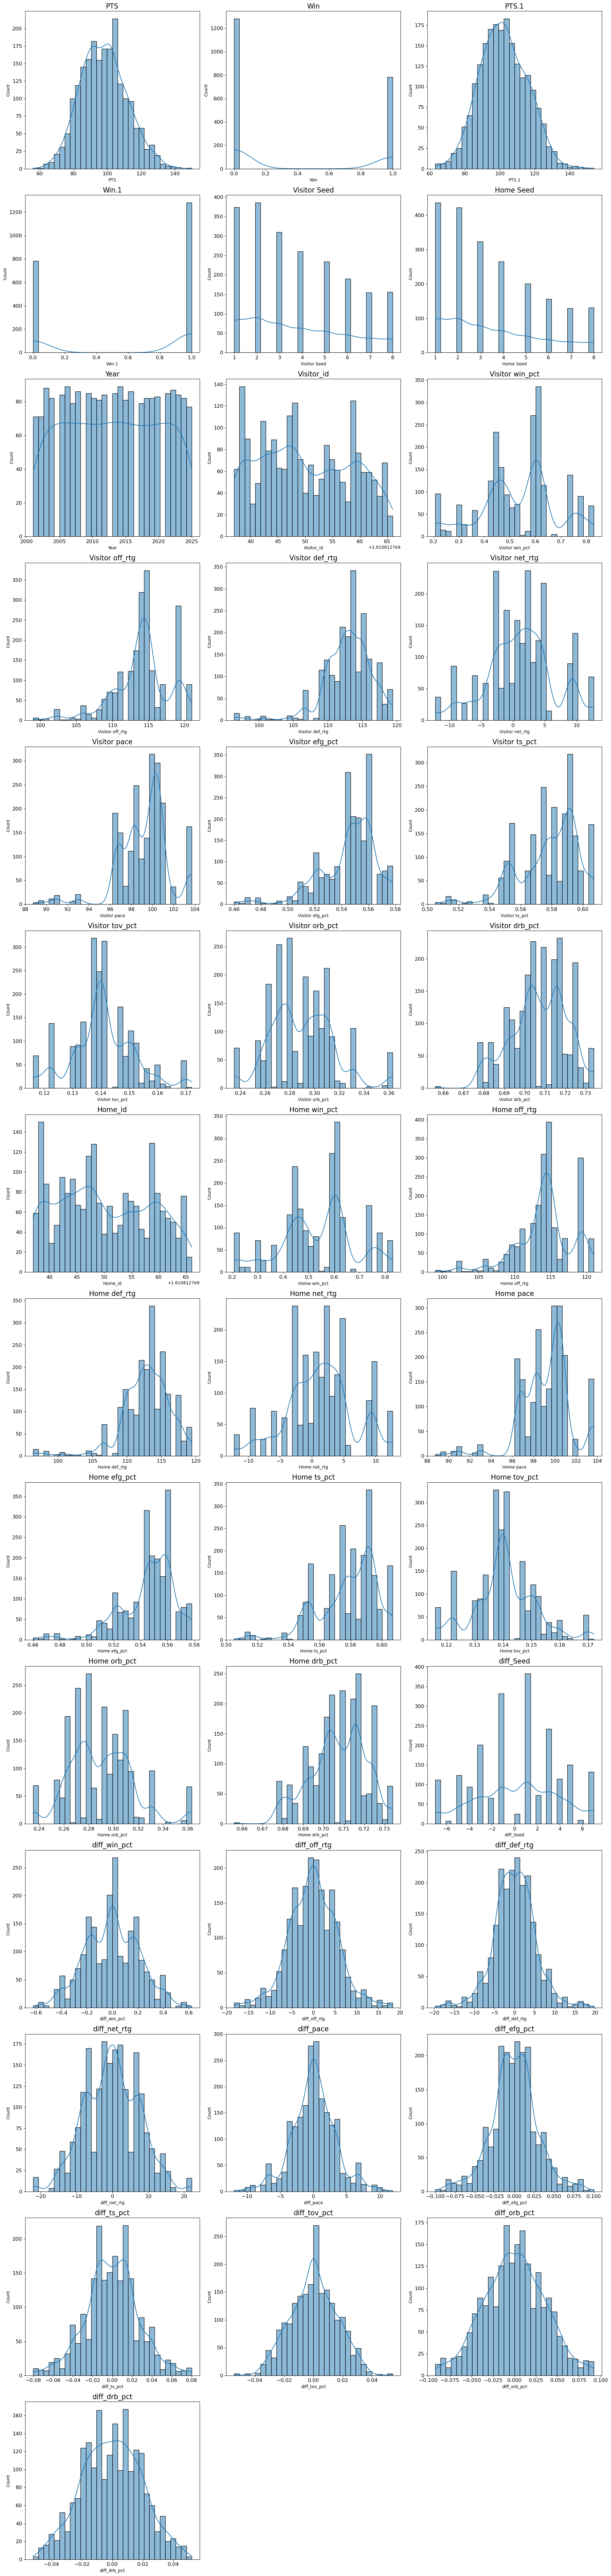

In [149]:
# Distribution of individual features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_per_row = 3
n = len(num_cols)
rows = (n + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(20, 6 * rows))
for i, col in enumerate(num_cols):
    ax = plt.subplot(rows, cols_per_row, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    ax.set_title(col, fontsize=16)
    ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

### 4. Model Building and Training

In [151]:
# Separate features and target
x = df[feature_columns].dropna()
y = df.loc[x.index, 'Win']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Initialize and train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Train Accuracy:", model.score(X_train, y_train))
y_pred = model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Train Accuracy: 0.7958812840702605
Test Accuracy: 0.57627


### 5. Model Tuning and Evaluation

In [152]:
# Hyperparameter Tuning
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2'],
'ccp_alpha': [0, 0.01, 0.1] }

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Cross-Validation to evaluate stability
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Best Hyperparameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-Validation Scores: [0.63141994 0.63333333 0.63333333 0.63333333 0.63030303]
Mean CV Accuracy: 0.6323445939760138


In [153]:
# Fine tine a new model to reduce overfitting
model_new = RandomForestClassifier(
n_estimators = 75,
max_depth = 7,
min_samples_split=6,
min_samples_leaf=7,
ccp_alpha=0,
max_features='sqrt',
random_state=42
)

# Evaluate
model_new.fit(X_train, y_train)
print("Train Accuracy:", model_new.score(X_train, y_train))
y_pred = model_new.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Train Accuracy: 0.7086614173228346
Test Accuracy: 0.61017


### 6. Create and Run Simulation

In [154]:
def get_team_stats(team_name):
    df_2025 = df[df['Year'] == 2025]
    
    # Find team in visitor column
    visitor_row = df_2025[df_2025['Visitor/Neutral'] == team_name]
    if not visitor_row.empty:
        row = visitor_row.iloc[0]
        return {metric: row[f'Visitor {metric}'] for metric in metrics}
    
    # Find team in home column
    home_row = df_2025[df_2025['Home/Neutral'] == team_name]
    if not home_row.empty:
        row = home_row.iloc[0]
        return {metric: row[f'Home {metric}'] for metric in metrics}

# Get team stats
thunder_stats = get_team_stats('Oklahoma City Thunder')
pacers_stats = get_team_stats('Indiana Pacers')

In [155]:
print(f"Thunder: {thunder_stats}")
print(f"Pacers: {pacers_stats}")

Thunder: {'Seed': 1, 'win_pct': 0.829, 'off_rtg': 119.2, 'def_rtg': 106.6, 'net_rtg': 12.7, 'pace': 100.9, 'efg_pct': 0.56, 'ts_pct': 0.593, 'tov_pct': 0.116, 'orb_pct': 0.281, 'drb_pct': 0.704}
Pacers: {'Seed': 4, 'win_pct': 0.61, 'off_rtg': 115.4, 'def_rtg': 113.3, 'net_rtg': 2.1, 'pace': 100.76, 'efg_pct': 0.562, 'ts_pct': 0.594, 'tov_pct': 0.13, 'orb_pct': 0.254, 'drb_pct': 0.705}


In [156]:
# Calculate probability that home wins
def calculate_game_probability(visitor_stats, home_stats):
    
    differences = [visitor_stats[metric] - home_stats[metric] for metric in metrics]
    return model_new.predict_proba([differences])[0][1]

# Calculate game probabilites for schedule format
home_schedule = ['OKC', 'OKC', 'IND', 'IND', 'OKC', 'IND', 'OKC']
game_probs = []

for i, home_team in enumerate(home_schedule):
    if home_team == 'OKC':
        # Thunder home, Pacers visitor
        prob_pacers_win = calculate_game_probability(pacers_stats, thunder_stats)
        prob_thunder_win = 1 - prob_pacers_win
    else:
        # Pacers home, Thunder visitor  
        prob_thunder_win = calculate_game_probability(thunder_stats, pacers_stats)
        prob_pacers_win = 1 - prob_thunder_win
    
    game_probs.append(prob_thunder_win)

In [157]:
# Run Monte Carlo Simulation
n_simulations = 10000
thunder_series_wins = 0
simulation_results = []
probability_tracking = []
np.random.seed(42)

for sim in range(n_simulations):
    thunder_wins = 0
    pacers_wins = 0
    
    for game in range(7):
        if np.random.random() < game_probs[game]:
            thunder_wins += 1
        else:
            pacers_wins += 1
        
        if thunder_wins == 4 or pacers_wins == 4:
            break
    
    if thunder_wins > pacers_wins:
        thunder_series_wins += 1

final_thunder_prob = thunder_series_wins / n_simulations
final_pacers_prob = 1 - final_thunder_prob

### 7. Results and Visualization

In [158]:
print("FINAL PREDICTION:")
print(f"Oklahoma City Thunder: {final_thunder_prob:.1%}")
print(f"Indiana Pacers: {final_pacers_prob:.1%}")

FINAL PREDICTION:
Oklahoma City Thunder: 78.4%
Indiana Pacers: 21.6%


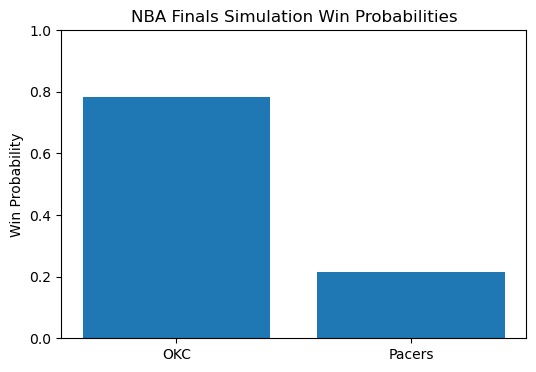

In [159]:
# Simple bar chart
plt.figure(figsize=(6, 4))
plt.bar(['OKC', 'Pacers'], [final_thunder_prob, final_pacers_prob])
plt.title('NBA Finals Simulation Win Probabilities')
plt.ylabel('Win Probability')
plt.ylim(0, 1)
plt.show()